# Entrenamiento de redes neuronales


## Funciones de costo y optimizadores

Para entrenar una red neuronal debemos definir 

1. Una función de costo: Lo "qué" vamos a minimizar
1. Un algoritmo de optimización: El "cómo" vamos a minimizar

Las funciones de costo están implementadas [`torch.nn`](https://pytorch.org/docs/stable/nn.html#loss-functions) y las más comunes son:

| Problema | Recibe | Etiqueta | Función de costo | 
|----| ----| ---- | ---- |
|Regresión | Real | Real | `torch.nn.MSELoss()` | 
|Clasificación | [0, 1] | {0, 1} | `torch.nn.BCELoss()` | 
|Clasificación | Real | {0, 1} | `torch.nn.BCEWithLogitsLoss()` |
|Clasificación (multiclase) | LogSoftmax | Entero |`torch.nn.LogLoss()` |
|Clasificación (multiclase) | Real | Entero |`torch.nn.CrossEntropyLoss()` |


Por ejemplo si queremos calcular el error medio cuadrático entre dos tensores

```python
criterion = torch.nn.MSELoss(reduction='mean')
loss = criterion(output, target)
```

:::{note}

También podemos crear nuestra propia función de costo. Por ejemplo podríamos lograr lo mismo que `MSELoss` habiendo definido `criterion = lambda ypred, y : (y-ypred).pow(2).mean()`

:::


Los algoritmos de optimización están implementados en el módulo [`torch.optim`](https://pytorch.org/docs/stable/optim.html?highlight=optim#module-torch.optim)


Los optimizadores más comunes son

| Optimizador | Descripción |
| ---- | ---- |
| `torch.optim.SGD` | Gradiente descedente estocástico con momentum|
| `torch.optim.Adam` | Gradiente descedente con tasa de aprendizaje y momentum adaptivo |



## Ajustando un modelo paso a paso

Consideremos el siguiente dataset $X$ con etiqueta $Y$, el cual deseamos clasificar con el modelo de la lección anterior:

In [113]:
import torch
import torch.nn as nn

X = torch.tensor([[-1.0, -1.0],
                  [-1.0, 1.0],
                  [1.0, -1.0],
                  [1.0, 1.0]])
Y = torch.tensor([[0.], [0.], [0.], [1.]])

model = nn.Sequential(nn.Linear(2, 2),
                      nn.Sigmoid(),
                      nn.Linear(2, 1))
model

Sequential(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=2, out_features=1, bias=True)
)

Dado que estamos en un escenario de clasificación binaria utilizaremos la entropía cruzada binaria como función de costo. Como optimizador utilizaremos el Adam

In [114]:
criterion = torch.nn.BCEWithLogitsLoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

Realizamos una predicción (inferencia) con:

In [115]:
hatY = model(X)
hatY

tensor([[0.8629],
        [0.8055],
        [0.6311],
        [0.5811]], grad_fn=<AddmmBackward0>)

Calculamos la función de pérdida:

In [116]:
loss = criterion(hatY, Y)
loss

tensor(3.8917, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

Calcular el gradiente de la función de pérdida:

In [93]:
loss.backward()
model[0].weight.grad, model[0].bias.grad

(tensor([[-0.0097, -0.0172],
         [ 0.0198, -0.0035]]),
 tensor([0.1538, 0.0707]))

In [94]:
model[2].weight.grad, model[2].bias.grad

(tensor([[0.2942, 0.3620]]), tensor([0.8358]))

Finalmente actualizamos los parámetros usando la función `step` de nuestro optimizador

In [95]:
model[0].weight, model[0].bias

(Parameter containing:
 tensor([[ 0.6388,  0.6338],
         [ 0.0545, -0.5311]], requires_grad=True),
 Parameter containing:
 tensor([-0.5628, -0.2815], requires_grad=True))

In [96]:
optimizer.step()

In [97]:
model[0].weight, model[0].bias

(Parameter containing:
 tensor([[ 0.7388,  0.7338],
         [-0.0455, -0.4311]], requires_grad=True),
 Parameter containing:
 tensor([-0.6628, -0.3815], requires_grad=True))

Este proceso se realiza iterativamente durante un cierto número de pasos o "épocas" de entrenamiento

In [112]:
for nepoch in range(1000):
    hatY = model.forward(X)
    optimizer.zero_grad()
    loss = criterion(hatY, Y)
    loss.backward()
    optimizer.step()
    if nepoch % 100 == 0:
        print(f"{nepoch} {loss.item():0.2f} {torch.nn.Sigmoid()(hatY).detach().squeeze(1)}")

0 3.03 tensor([0.5600, 0.5389, 0.5577, 0.5410])
100 1.72 tensor([0.1784, 0.2127, 0.2475, 0.3678])
200 0.98 tensor([0.0981, 0.1529, 0.1702, 0.5933])
300 0.47 tensor([0.0512, 0.0844, 0.0901, 0.7904])
400 0.27 tensor([0.0323, 0.0503, 0.0534, 0.8779])
500 0.18 tensor([0.0226, 0.0337, 0.0357, 0.9191])
600 0.13 tensor([0.0169, 0.0245, 0.0258, 0.9418])
700 0.10 tensor([0.0132, 0.0187, 0.0196, 0.9557])
800 0.08 tensor([0.0106, 0.0148, 0.0155, 0.9650])
900 0.06 tensor([0.0088, 0.0120, 0.0126, 0.9715])


## Esquema general de entrenamiento en PyTorch

Habiendo definido el modelo, el criterio, el optimizador y los datos, el esquema general de entrenamiento sería:

``` python
for epoch in range(num_epochs): # Durante un cierto número de épocas
    for minibatch in data: # Para cada minibatch de datos
        optimizer.zero_grad() # Limpiamos los gradientes
        x, y = minibatch # Desempaquetamos
        yhat = model.forward(x) # Predecimos
        loss = criterion(yhat, y) # Evaluamos
        loss.backward() # Calculamos los gradientes
        optimizer.step() # Actualizamos los parámetros
```

donde

- Una época es una presentación completa del conjunto de entrenamiento
- Un minibatch es un subconjunto del conjunto de entrenamiento

Consideremos un conjunto de entrenamiento con datos bidimensionales y dos clases como el siguiente

:::{note}

Este conjunto no es linealmente separable

:::

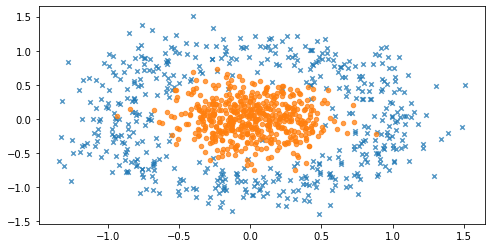

In [119]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
data, labels = sklearn.datasets.make_circles(n_samples=1000, noise=0.2, factor=0.25)

fig, ax = plt.subplots(figsize=(8, 4))
for k, marker in enumerate(['x', 'o']):
    ax.scatter(data[labels==k, 0], data[labels==k, 1], s=20, marker=marker, alpha=0.75)
    
# Para las gráficas
x_min, x_max = data[:, 0].min() - 0.5, data[:, 0].max() + 0.5
y_min, y_max = data[:, 1].min() - 0.5, data[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05), np.arange(y_min, y_max, 0.05))

1. Antes de empezar el entrenamiento convertimos los datos a formato tensor de PyTorch
1. Luego presentamos los datos en *mini-batches* a la red neuronal en cada época del entrenamiento

PyTorch provee las clases `DataSet` y `DataLoader` para lograr estos objetivos

Estas clases son parte del módulo data: https://pytorch.org/docs/stable/data.html


Crearemos un set a partir de tensores usando una clase que hereda de `DataSet`

```python
    torch.utils.data.TensorDataset(*tensors # Una secuencia de tensores
                                  )
```    
Luego crearemos conjuntos de entrenamiento y validación usando 

```python
    torch.utils.data.Subset(dataset, # Un objeto que herede de DataSet
                            indices # Un conjunto de índices para seleccionar un subconjunto de dataset
                           )
```    
Finalmente crearemos dataloaders usando

```python
    torch.utils.data.DataLoader(dataset, # Un objeto que herede de DataSet
                                batch_size=1, # Tamaño del minibatch 
                                shuffle=False, # Entregar los minibatches desordenados
                                sampler=None, # O especificar una muestreador customizado
                                num_workers=0, # Cuantos nucleos de CPU usar
                                ...
                               )
```


In [ ]:
import sklearn.model_selection
# Separamos el data set en entrenamiento y validación
train_idx, valid_idx = next(sklearn.model_selection.ShuffleSplit(train_size=0.6).split(data, labels))


# Crear conjuntos de entrenamiento y prueba
from torch.utils.data import DataLoader, TensorDataset, Subset 

# Creamos un conjunto de datos en formato tensor
torch_set = TensorDataset(torch.from_numpy(data.astype('float32')), 
                          torch.from_numpy(labels.astype('float32')))

# Data loader de entrenamiento
torch_train_loader = DataLoader(Subset(torch_set, train_idx), shuffle=True, batch_size=32)
# Data loader de validación
torch_valid_loader = DataLoader(Subset(torch_set, valid_idx), shuffle=False, batch_size=256)

Los `DataLoader` se ocupan como iteradores de Python

In [ ]:
for sample_data, sample_label in torch_train_loader:
    display(sample_data.shape)
    display(sample_label.shape)
    display(sample_label)
    break

#### Recordemos

Para cada dato de entrenamiento:
- Calculamos gradientes: `loss.backward`
- Actualizamos parámetros `optimizer.step`

Para cada dato de validación
- Evaluamos la *loss* para detectar sobre-ajuste



#### ¿Cuándo nos detenemos?

Lo ideal es detener el entrenamiento cuando la loss de validación no haya disminuido durante una cierta cantidad de épocas

Podemos usar [`save`](https://pytorch.org/tutorials/beginner/saving_loading_models.html) para ir guardando los parámetros del mejor modelo de validación

Usamos un número fijo de épocas como resguardo: Si el modelo no ha convergido entonces debemos incrementarlo

#### ¿Cómo afecta el resultado el número de neuronas en la capa oculta?

In [ ]:
def train_one_epoch(k, model, criterion, optimizer):
    global best_valid
    train_loss, valid_loss = 0.0, 0.0
    
    # Loop de entrenamiento
    for sample_data, sample_label in torch_train_loader:
        output = model.forward(sample_data)
        optimizer.zero_grad()        
        loss = criterion(output, sample_label.unsqueeze(1))  
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        
    # Loop de validación
    for sample_data, sample_label in torch_valid_loader:
        output = model.forward(sample_data)
        loss = criterion(output, sample_label.unsqueeze(1))  
        valid_loss += loss.item()
        
    # Guardar modelo si es el mejor hasta ahora
    if k % 10 == 0:
        if valid_loss < best_valid:
            best_valid = valid_loss
            torch.save({'epoca': k,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': valid_loss}, '/home/phuijse/modelos/best_model.pt')
    
    return train_loss/torch_train_loader.dataset.__len__(), valid_loss/torch_valid_loader.dataset.__len__()

In [ ]:
model = MultiLayerPerceptron(input_dim=2, output_dim=1, hidden_dim=3)
criterion = torch.nn.BCELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
n_epochs = 200
running_loss = np.zeros(shape=(n_epochs, 2))

best_valid = np.inf

In [ ]:
def update_plot(k):
    global model, running_loss
    [ax_.cla() for ax_ in ax]
    running_loss[k, 0], running_loss[k, 1] = train_one_epoch(k, model, criterion, optimizer)
    
    Z = model.forward(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()].astype('float32')))
    Z = Z.detach().numpy().reshape(xx.shape)
    ax[0].contourf(xx, yy, Z, cmap=plt.cm.RdBu_r, alpha=1., vmin=0, vmax=1)
    for i, (marker, name) in enumerate(zip(['o', 'x'], ['Train', 'Test'])):
        ax[0].scatter(data[labels==i, 0], data[labels==i, 1], color='k', s=10, marker=marker, alpha=0.5)
        ax[1].plot(np.arange(0, k+1, step=1), running_loss[:k+1, i], '-', label=name+" cost")
    plt.legend(); ax[1].grid()

fig, ax = plt.subplots(1, 2, figsize=(8, 3.5), tight_layout=True)
#update_plot(0)
anim = animation.FuncAnimation(fig, update_plot, frames=n_epochs, 
                               interval=10, repeat=False, blit=False)

Neuronas de capa oculta:

In [ ]:
fig, ax = plt.subplots(1, model.hidden.out_features, figsize=(8, 3), tight_layout=True)

Z = model.hidden(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()].astype('float32'))).detach().numpy()
Z = 1/(1+np.exp(-Z))
for i in range(model.hidden.out_features):
    ax[i].contourf(xx, yy, Z[:, i].reshape(xx.shape), 
                   cmap=plt.cm.RdBu_r, alpha=1., vmin=np.amin(Z), vmax=np.amax(Z))

#### Recuperando el mejor modelo

In [ ]:
model = MultiLayerPerceptron(hidden_dim=3)

print("state_dict del módelo:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
    print(param_tensor, "\t", model.state_dict()[param_tensor])


    
model.load_state_dict(torch.load('/home/phuijse/modelos/best_model.pt')['model_state_dict'])

print(" ")
print("state_dict del módelo recuperado:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
    print(param_tensor, "\t", model.state_dict()[param_tensor])



## Diagnósticos a partir de curvas de aprendizaje

Podemos diagnosticar el entrenamiento observando la evolución de la función de costo 

:::{important}

Siempre visualiza la loss en ambos conjuntos: entrenamiento y validación

:::

Veamos algunos casos

**Ambas curvas en descenso**

Si las curvas se ven así:

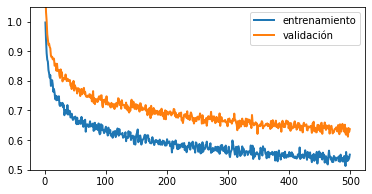

In [120]:
epochs = np.arange(1, 500)
loss_train = (epochs)**(-1/10) + 0.01*np.random.randn(len(epochs))
loss_valid = (epochs)**(-1/10) + 0.01*np.random.randn(len(epochs)) + 0.1
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(epochs, loss_train, lw=2, label='entrenamiento')
ax.plot(epochs, loss_valid, lw=2, label='validación')
ax.set_ylim([0.5, 1.05])
plt.legend();

En este caso deberías continuar con el entrenamiento, pues no hay señal de convergencia

**Sobreajuste temprano**

Si las curvas se ven así:

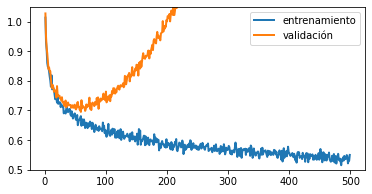

In [121]:
epochs = np.arange(1, 500)
loss_train = (epochs)**(-1/10) + 0.01*np.random.randn(len(epochs))
loss_valid = (epochs)**(-1/10) + 0.00001*(epochs)**2 +0.01*np.random.randn(len(epochs)) + 0.01
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(epochs, loss_train, lw=2, label='entrenamiento')
ax.plot(epochs, loss_valid, lw=2, label='validación')
ax.set_ylim([0.5, 1.05])
plt.legend();

Significa que tu modelo se ha sobreajustado, por ende:

- Implementa un modelo más sencillo
- Consigue más datos
- Considera utilizar regularización 

**Error en el código o mal punto de partida**

Si tus curvas se ven así:

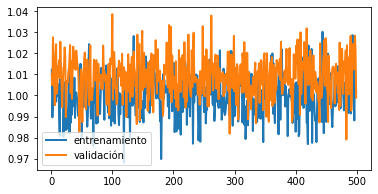

In [122]:
epochs = np.arange(1, 500)
loss_train = 1.0 + 0.01*np.random.randn(len(epochs))
loss_valid = 1.0 + 0.01*np.random.randn(len(epochs)) + 0.01
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(epochs, loss_train, lw=2, label='entrenamiento')
ax.plot(epochs, loss_valid, lw=2, label='validación')
#ax.set_ylim([0.5, 1.05])
plt.legend();

Revisa que tu código no tenga bugs, en particular que el modelo no esté retornando `nans`, que la función de costo sea adecuada para el problema y que la taza de aprendizaje no sea demasiado alta

También puede deberse a una muy mala inicialización aleatoria, reinicia el entrenamiento para comprobar si es el caso